# Tutorial for using stagewiseNN

TODO:
    Add some descriptions

In [1]:
import os
import sys
from pathlib import Path
from typing import Sequence, Mapping, Optional, Union, Callable
import logging
import pandas as pd
import numpy as np
import scanpy as sc

ROOT = Path('../')  
sys.path.append(str(ROOT))

import swnn
from swnn.utils.process import describe_dataframe, set_adata_hvgs, change_names

DATADIR = ROOT / 'sample_data'

In [2]:
def get_adata(datadir=DATADIR, ):
    path = datadir / 'merged_B-L0-0.2.h5ad'
    adata = sc.read_h5ad(path)
    return adata


def get_high_freq_hvgs(min_freq=3, datadir=DATADIR):
    hvg_freq = pd.read_csv(
        datadir / 'hvg_frequencies.csv', index_col=0, header=None)
    hvg_freq = hvg_freq.iloc[:, 0]
    return hvg_freq[hvg_freq >= min_freq].index.tolist()


def formulate_adata(adata, save_path=None):
    adata.obs.columns = change_names(
        adata.obs.columns, stage='stage_id', )
    adata.obs['lineage'] = change_names(
        adata.obs['lineage'],
        {'Tail bud stem cells': 'Unassigned'}
    )
    adata.obs['stage_primer'] = adata.obs[['stage_name', 'primer']].apply(
        lambda x: '_'.join(x), axis=1
    )
    adata.obs['stagewise_cluster'] = adata.obs[['stage_name', 'leiden_new']].apply(
        lambda x: '_'.join(x), axis=1
    )
    adata.obs['stagewise_cluster'] = change_names(
        adata.obs['stagewise_cluster'],
        {'B_1': 'B_0', 'B_2': 'B_1', 'B_3': 'B_2'}
    )

    if save_path is not None:
        adata.write(save_path)
    return adata


def _inspect_data(log_file=None):
    adata = get_adata()
    adata = formulate_adata(adata)
    print(adata, file=log_file)
    describe_dataframe(adata.obs, file=log_file)
    # TODO: additional markers of prior knowledge
    hvgs = get_high_freq_hvgs()
    print('Total of %d HVGs are used.', len(hvgs), file=log_file)


In [3]:
resdir = ROOT / '_temp'
swnn.check_dirs(resdir)

adata0 = get_adata()
adata0 = formulate_adata(adata0)
# TODO: additional markers of prior knowledge
hvgs = get_high_freq_hvgs()
adata = swnn.quick_preprocess_raw(
    adata0, hvgs=hvgs, copy=True, batch_key='stage_primer')

X = adata.X
stage_lbs = adata.obs['stage_name']
stage_order = ("B", "G3", "G4", "G5", "G6", "N0", "N1", "N3", "L0")
ks = [10] * 7 + [5] + [3]
n_pcs = [30] * 5 + [50] * 4

already exists:
	../_temp


In [4]:
distmat, connect = swnn.stagewise_knn(
    X, stage_lbs, stage_order,
    k=ks,
    leaf_size=1, # 1 for brute-force KNN
    pca_base_on='stacked',
    n_pcs=n_pcs,
    binary_edge=False,
    )
connect_bin = swnn.make_binary(connect)
swnn.set_precomputed_neighbors(adata, distmat, connect_bin, )

AnnData object with n_obs × n_vars = 29775 × 3569
    obs: 'stage_id', 'primer', 'n_genes', 'n_counts', 'stage_primer', 'stg_leiden', 'stage_stg_leiden', 'refined_group', 'leiden_new', 'parent_bcd', 'lineage', 'stage_name', 'stagewise_cluster'
    var: 'highly_variable'
    uns: 'log1p', 'neighbors'
    obsp: 'distances', 'connectivities'

In [ ]:
# sc.tl.umap(adata, min_dist=0.1)
# sc.settings.figdir = resdir
# sc.set_figure_params(fontsize=14)
#
# lin_colors = pd.read_csv(
#     'sample_data/lineage_colors.csv', index_col=0).iloc[:, 0]
# adata.obs['lineage'] = pd.Categorical(
#     adata.obs['lineage'], categories=lin_colors.index)
# adata.uns['lineage_colors'] = lin_colors.tolist()
# sc.pl.umap(adata, color='lineage', ncols=1, save='_lineage.pdf')
# sc.pl.umap(adata, color='stage_name', palette='plasma_r', save='_stage.pdf')

connecting stage B and G3
---> aggregating edges...
unique labels of rows: ['B_1' 'B_0' 'B_2']
unique labels of columns: ['G3_1' 'G3_0' 'G3_3' 'G3_4' 'G3_2' 'G3_5']
grouping elements (edges)
shape of the one-hot-labels: (1596, 3) (1826, 6)
parent nodes that had no descendent: ['B_2']
Taking descendant-points from other nodes (groups)
pasting stage labels
---> aggregating edges...
unique labels of rows: ['B_1' 'B_0' 'B_2']
unique labels of columns: ['G3_1' 'G3_0' 'G3_3' 'G3_4' 'G3_2' 'G3_5' 'G3_6']
grouping elements (edges)
shape of the one-hot-labels: (1596, 3) (1826, 7)

connecting stage G3 and G4
---> aggregating edges...
unique labels of rows: ['G3_0', 'G3_1', 'G3_2', 'G3_3', 'G3_4', 'G3_5', 'G3_6']
unique labels of columns: ['G4_0' 'G4_4' 'G4_2' 'G4_3' 'G4_1']
grouping elements (edges)
shape of the one-hot-labels: (1826, 7) (1477, 5)
parent nodes that had no descendent: ['G3_3', 'G3_6']
Taking descendant-points from other nodes (groups)
pasting stage labels
---> aggregating edges..

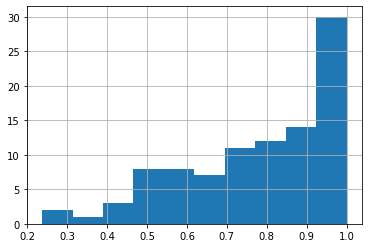

In [5]:
from scipy import sparse
obs = adata.obs
group_lbs = obs['stagewise_cluster'].values
stage_lbs = obs['stage_name'].values
KEY_TREE_NODE = 'tree_node'

# graph to tree
conn_upper = sparse.triu(connect).tocsc()
adj_max = swnn.max_connection(conn_upper)
edgedf, new_group_lbs = swnn.adaptive_tree(
    adj_max, group_lbs, stage_lbs=stage_lbs, stage_ord=stage_order)

obs[KEY_TREE_NODE] = new_group_lbs
edgedf.prop.hist() # voting proportions
logging.info("edgedf = %s", edgedf)

df_tree = edgedf[['node', 'parent']].copy()
df_tree['label'] = df_tree['node'].copy()
df_tree['stage'] = df_tree['node'].apply(lambda x: x.split('_')[0])
groupby = KEY_TREE_NODE
props_all = swnn.group_mean_adata(adata, groupby, use_raw=True, binary=True)
means_all = swnn.group_mean_adata(adata, groupby, use_raw=True, )


In [ ]:
# props_all.to_csv(resdir / f'expr_prop_all.csv', index=True, header=True)
# means_all.to_csv(resdir / f'avg_expr_all.csv', index=True, header=True)